In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_validate

In [ ]:
X,y = load_diabetes(as_frame=True, return_X_y=True)

In [ ]:
def evaluateModel(model, X, y, printRes = True):
  pred = model.predict(X)
  mse = mean_squared_error(y, pred)
  r2 = r2_score(y, pred)

  if (printRes):
    #print("Coefficients: \n", model.coef_)
    print("Coefficients: %.2f"%(np.sum(model.coef_)))
    for i in model.coef_:
      print("%8.2f "%i, end='')
    print("\nMean squared error: %.2f" % mse)
    print("Coefficient of determination: %.2f" % r2)

  return mse, r2

In [ ]:
X_train, X_vali, y_train, y_vali = train_test_split(X,y, test_size=0.20)

lr = LinearRegression()
lr.fit(X_train, y_train)
evaluateModel(lr, X_train, y_train)
evaluateModel(lr, X_vali, y_vali)


Coefficients: 1318.94
  -25.04  -312.01   498.46   332.52  -715.57   421.46    89.39    77.27   848.97   103.50 
Mean squared error: 2767.35
Coefficient of determination: 0.54
Coefficients: 1318.94
  -25.04  -312.01   498.46   332.52  -715.57   421.46    89.39    77.27   848.97   103.50 
Mean squared error: 3452.43
Coefficient of determination: 0.36


(3452.430784115008, 0.36190081177923783)

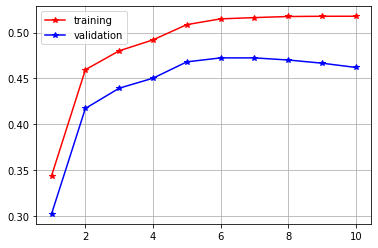

[['bmi'], ['bmi', 's5'], ['bmi', 'bp', 's5'], ['bmi', 'bp', 's1', 's5'], ['sex', 'bmi', 'bp', 's3', 's5'], ['sex', 'bmi', 'bp', 's1', 's2', 's5'], ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5'], ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6'], ['sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']]
[0.3439237602253803, 0.4594852440167805, 0.48008281990946056, 0.49201619828699905, 0.5086324897618718, 0.5148848325387045, 0.5162912373528604, 0.5174713510884763, 0.5177180065591446, 0.5177494254132934]


In [ ]:
from itertools import combinations

def selectFromAll(model, X,y):
  best_r2   = []
  best_pair  = []
  for k in range(1, len(X.columns)+1):
    # Gera todas as combinações
    comb = combinations(X.columns, k) 
    r2_set  = []
    pairs   = []
    for i in list(comb):
      model.fit(X[list(i)], y)       
      mse, r2 = evaluateModel(model, X[list(i)], y, printRes = False)
      pairs.append(list(i))
      r2_set.append(r2)
      
    # Escolhe a melhor
    best_pos = np.argmax(r2_set)
    best_r2.append( r2_set[best_pos] )
    best_pair.append( pairs[best_pos] )

  return best_r2, best_pair

lr = LinearRegression()
best_r2, best_pair = selectFromAll(lr, X, y)
plt.plot(np.arange(1,len(X.columns)+1), best_r2,"r*-", label='training')
best_r2_cv = []
for i in range(len(best_pair)):
  cv_results = cross_validate(lr, X[best_pair[i]], y, cv=10, scoring=('r2'))
  best_r2_cv.append( np.mean(cv_results['test_score']) )
plt.plot(np.arange(1,len(X.columns)+1), best_r2_cv,"b*-", label='validation')
plt.legend()
plt.grid()
plt.show()

print(best_pair)
print(best_r2)



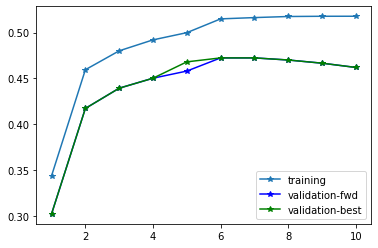

[['bmi'], ['bmi', 's5'], ['bmi', 's5', 'bp'], ['bmi', 's5', 'bp', 's1'], ['bmi', 's5', 'bp', 's1', 'sex'], ['bmi', 's5', 'bp', 's1', 'sex', 's2'], ['bmi', 's5', 'bp', 's1', 'sex', 's2', 's4'], ['bmi', 's5', 'bp', 's1', 'sex', 's2', 's4', 's6'], ['bmi', 's5', 'bp', 's1', 'sex', 's2', 's4', 's6', 's3'], ['bmi', 's5', 'bp', 's1', 'sex', 's2', 's4', 's6', 's3', 'age']]
[0.3439237602253803, 0.4594852440167805, 0.48008281990946045, 0.49201619828699916, 0.49986101067387156, 0.5148848325387045, 0.5162912373528603, 0.5174713510884762, 0.5177180065591446, 0.5177494254132934]


In [ ]:
def selectForward(model, X,y):

  fwd_r2   = []
  fwd_pair  = []
  best = []
  predictors = X.columns.to_list()
  for k in range(1, len(X.columns)+1):    
    r2_set  = []
    pairs   = []
    for i in list(predictors):
      pair = best+[i]
      model.fit(X[pair], y)       
      mse, r2 = evaluateModel(model, X[pair], y, printRes = False)
      pairs.append(pair)
      r2_set.append(r2)
      
    # Escolhe a melhor
    best_pos = np.argmax(r2_set)    
    fwd_r2.append( r2_set[best_pos] )    
    best = pairs[best_pos]
    predictors.remove( best[-1] )
    fwd_pair.append( best )

  return fwd_r2, fwd_pair

lr = LinearRegression()
fwd_r2, fwd_pair = selectForward(lr, X, y)
plt.plot(np.arange(1,len(X.columns)+1), fwd_r2,"*-", label='training')
fwd_r2_cv = []
for i in range(len(best_pair)):
  cv_results = cross_validate(lr, X[fwd_pair[i]], y, cv=10, scoring=('r2'))
  fwd_r2_cv.append( np.mean(cv_results['test_score']) )
plt.plot(np.arange(1,len(X.columns)+1), fwd_r2_cv,"b*-", label='validation-fwd')
plt.plot(np.arange(1,len(X.columns)+1), best_r2_cv,"g*-", label='validation-best')
plt.legend()
plt.show()

print(fwd_pair)
print(fwd_r2)

# Regularização

[Linear Regression no Scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html)

In [ ]:
from sklearn.linear_model import Ridge, Lasso

X_train, X_vali, y_train, y_vali = train_test_split(X,y, test_size=0.20)

ridge = Ridge()
ridge.fit(X_train, y_train)
evaluateModel(ridge, X_train, y_train)
evaluateModel(ridge, X_vali, y_vali)


Coefficients: 723.94
   12.40   -85.11   292.16   166.88    18.06   -12.99  -146.31   129.98   241.34   107.53 
Mean squared error: 3227.31
Coefficient of determination: 0.45
Coefficients: 723.94
   12.40   -85.11   292.16   166.88    18.06   -12.99  -146.31   129.98   241.34   107.53 
Mean squared error: 3799.89
Coefficient of determination: 0.37


(3799.89066700602, 0.36586119955848284)

In [ ]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

kf = KFold(n_splits=5)#, shuffle=True)
#cv_results = cross_validate(lr, X, y, cv=kf, scoring=('r2', 'neg_mean_squared_error'))
cv_results = cross_validate(lr, X, y, cv=kf, scoring=('r2'))
print('LR mean R2 =', np.mean(cv_results['test_score']))
print(cv_results['test_score'])

cv_results = cross_validate(ridge, X, y, cv=kf, scoring=('r2'))
print('Ridge mean R2 =', np.mean(cv_results['test_score']))
print(cv_results['test_score'])

cv_results = cross_validate(lasso, X, y, cv=kf, scoring=('r2'))
print('Lasso mean R2 =', np.mean(cv_results['test_score']))
print(cv_results['test_score'])

# Dados já vem normalizados, mas se não viessem , poderia usar o StandardScaler do Python

LR mean R2 = 0.48231812211149394
[0.42955643 0.52259828 0.4826784  0.42650827 0.55024923]
Ridge mean R2 = 0.4101758336587286
[0.32166426 0.44048429 0.42210466 0.42466353 0.44196242]
Lasso mean R2 = 0.3375597834274946
[0.28349047 0.35157959 0.3533813  0.33481474 0.36453281]


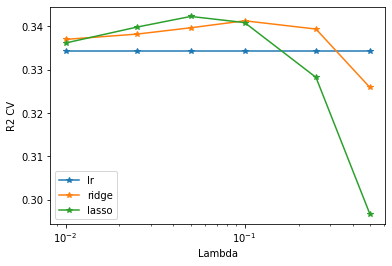

In [ ]:
ridge_l = []
lasso_l = []
lr_l = []

ls = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5]
kf = KFold(n_splits=50, shuffle=True, random_state=21)
for l in ls:
  lr = LinearRegression()
  ridge = Ridge(alpha=l)
  lasso = Lasso(alpha=l)

  #cv_results = cross_validate(lr, X, y, cv=kf, scoring=('r2', 'neg_mean_squared_error'))
  cv_results = cross_validate(lr, X, y, cv=kf, scoring=('r2'))
  lr_l.append( np.mean(cv_results['test_score'] ))

  cv_results = cross_validate(ridge, X, y, cv=kf, scoring=('r2'))
  ridge_l.append( np.mean(cv_results['test_score']))  

  cv_results = cross_validate(lasso, X, y, cv=kf, scoring=('r2'))
  lasso_l.append( np.mean(cv_results['test_score']))

plt.plot (ls, lr_l, '-*', label = 'lr')
plt.plot (ls, ridge_l, '-*',label = 'ridge')
plt.plot (ls, lasso_l, '-*',label = 'lasso')
plt.xlabel('Lambda')
plt.ylabel('R2 CV')
plt.xscale('log')
plt.legend()
plt.show()


In [ ]:
X_train, X_vali, y_train, y_vali = train_test_split(X,y, test_size=0.20)

print(X.columns)

print("\n=== LR ===")
lr = LinearRegression()
lr.fit(X_train, y_train)
#evaluateModel(lr, X_train, y_train)
evaluateModel(lr, X_vali, y_vali)

print("\n=== Lasso ===")
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)
#evaluateModel(lasso, X_train, y_train)
evaluateModel(lasso, X_vali, y_vali)

print("\n=== Ridge ===")
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
#evaluateModel(ridge, X_train, y_train)
evaluateModel(ridge, X_vali, y_vali)


Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

=== LR ===
Coefficients: 1397.31
   19.95  -247.37   528.45   351.03  -729.05   378.77    99.79   283.50   684.14    28.11 
Mean squared error: 3210.01
Coefficient of determination: 0.45

=== Lasso ===
Coefficients: 947.48
    0.00  -196.27   534.22   327.57  -130.81    -0.00  -187.21    88.29   492.92    18.77 
Mean squared error: 3193.17
Coefficient of determination: 0.45

=== Ridge ===
Coefficients: 914.52
   26.70  -205.31   490.61   319.81   -74.41   -88.68  -189.25   166.73   409.18    59.15 
Mean squared error: 3215.82
Coefficient of determination: 0.44


(3215.8245465783684, 0.44488544048356227)